In [ ]:
import os
spark_version = 'spark-3.0.2'
os.environ['spark-3.0.2']=spark_version
# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.0.2/spark-3.0.2-bin-hadoop2.7.tgz
!tar xf spark-3.0.2-bin-hadoop2.7.tgz
!pip install -q findspark
# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.2-bin-hadoop2.7"
# Start a SparkSession
import findspark
findspark.init()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:2 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:14 http://securit

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("BigData-Challenge").config("spark.driver.extraClassPath").getOrCreate()

### Load Amazon Data into Spark DataFrame

In [ ]:
from pyspark import SparkFiles
url = "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Watches_v1_00.tsv.gz"
spark.sparkContext.addFile(url)
df = spark.read.option("encoding", "UTF-8").csv(SparkFiles.get(""), sep="\t", header=True, inferSchema=True)
df.show()

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|         US|    3653882|R3O9SGZBVQBV76|B00FALQ1ZC|     937001370|Invicta Women's 1...|         Watches|          5|            0|          0|   N|                Y|          Five Stars|Absolutely love t...| 2015-08-31|
|         US|   14661224| RKH8BNC3L5DLF|B00D3RGO20|     484010722|Kenneth Cole New ...|         Watches|          5|    

In [ ]:
#to check the datatypes in the dataframe
df.schema

StructType(List(StructField(marketplace,StringType,true),StructField(customer_id,IntegerType,true),StructField(review_id,StringType,true),StructField(product_id,StringType,true),StructField(product_parent,IntegerType,true),StructField(product_title,StringType,true),StructField(product_category,StringType,true),StructField(star_rating,IntegerType,true),StructField(helpful_votes,IntegerType,true),StructField(total_votes,IntegerType,true),StructField(vine,StringType,true),StructField(verified_purchase,StringType,true),StructField(review_headline,StringType,true),StructField(review_body,StringType,true),StructField(review_date,StringType,true)))

### Create DataFrames to match tables

In [ ]:
from pyspark.sql.functions import to_date
# Read in the Review dataset as a DataFrame
customer_clean_df = df.dropna()
customer_clean_df.show()

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|         US|    3653882|R3O9SGZBVQBV76|B00FALQ1ZC|     937001370|Invicta Women's 1...|         Watches|          5|            0|          0|   N|                Y|          Five Stars|Absolutely love t...| 2015-08-31|
|         US|   14661224| RKH8BNC3L5DLF|B00D3RGO20|     484010722|Kenneth Cole New ...|         Watches|          5|    

In [ ]:
# Drop duplicates
customer_clean_1_df = customer_clean_df.drop_duplicates()
customer_clean_1_df.show(10)

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|         US|   43765005|R1006OPQYUMAHS|B0000TIIZ0|     529990321|Timex Women's T47...|         Watches|          1|            4|          5|   N|                Y|   Not very happy...|[[ASIN:B0000TIIZ0...| 2008-03-05|
|         US|   44007561|R1010XUX2AIF10|B004KTK2M8|      38406392|Leather Watchband...|         Watches|          5|    

In [ ]:
# Create the customers_table DataFrame
customers_df = customer_clean_df.groupby("customer_id").agg({"customer_id":"count"}).withColumnRenamed("count(customer_id)", "customer_count")
customers_df.show(5)

+-----------+--------------+
|customer_id|customer_count|
+-----------+--------------+
|    1567510|             1|
|   19502021|             1|
|   12819130|             1|
|   35329257|             2|
|     108460|             1|
+-----------+--------------+
only showing top 5 rows



In [ ]:
customers_df.schema

StructType(List(StructField(customer_id,IntegerType,true),StructField(customer_count,LongType,false)))

In [ ]:
# Create the products_table DataFrame and drop duplicates.
#df.filter("price<20").select("points","country","price").show(5)
products_df = customer_clean_df.select(["product_id","product_title"]).drop_duplicates()
products_df.show(20)

+----------+--------------------+
|product_id|       product_title|
+----------+--------------------+
|B00EVX7V1I|Game Time Women's...|
|B009S4DODY|XOXO Women's XO55...|
|B00LBKXQRW|Anne Klein Women'...|
|B0009P679Y|Invicta Men's 993...|
|B00DHF30RU|M&c Women's | Cla...|
|B00NIDA43Y|GuTe Classic Skel...|
|B008EQDDPQ|Nautica Men's N13...|
|B004VRBZ66|Timex Men's T2N63...|
|B009BEO81I|        Fossil Riley|
|B008B39MTI|XOXO Women's XO55...|
|B00TGPM8PU|Handmade Wooden W...|
|B00VNXQQQ0|Eterna 2520-41-64...|
|B00B1PV1C4|Nautica Men's N19...|
|B00N1Y8TQ4|Tissot Men's T095...|
|B00G6DBTY6|red line Men's RL...|
|B00HM04AYI|Columbia Men's Fi...|
|B00VI8HB96|GUESS I90176L1 Wo...|
|B00IT25WJU|LanTac DGN556B Dr...|
|B0106S12XE|Skmei S Shock Ana...|
|B00FPSJ63Y|Michael Kors Ladi...|
+----------+--------------------+
only showing top 20 rows



In [ ]:
products_df.schema

StructType(List(StructField(product_id,StringType,true),StructField(product_title,StringType,true)))

In [ ]:
# Create the review_id_table DataFrame.
# Convert the 'review_date' column to a date datatype with to_date("review_date", 'yyyy-MM-dd').alias("review_date")
review_id_df = customer_clean_df.select(["review_id","customer_id","product_id","product_parent",to_date("review_date", 'yyyy-MM-dd').alias("review_date")])
review_id_df.show(10)

+--------------+-----------+----------+--------------+-----------+
|     review_id|customer_id|product_id|product_parent|review_date|
+--------------+-----------+----------+--------------+-----------+
|R3O9SGZBVQBV76|    3653882|B00FALQ1ZC|     937001370| 2015-08-31|
| RKH8BNC3L5DLF|   14661224|B00D3RGO20|     484010722| 2015-08-31|
|R2HLE8WKZSU3NL|   27324930|B00DKYC7TK|     361166390| 2015-08-31|
|R31U3UH5AZ42LL|    7211452|B000EQS1JW|     958035625| 2015-08-31|
|R2SV659OUJ945Y|   12733322|B00A6GFD7S|     765328221| 2015-08-31|
| RA51CP8TR5A2L|    6576411|B00EYSOSE8|     230493695| 2015-08-31|
| RB2Q7DLDN6TH6|   11811565|B00WM0QA3M|     549298279| 2015-08-31|
|R2RHFJV0UYBK3Y|   49401598|B00A4EYBR0|     844009113| 2015-08-31|
|R2Z6JOQ94LFHEP|   45925069|B00MAMPGGE|     263720892| 2015-08-31|
| RX27XIIWY5JPB|   44751341|B004LBPB7Q|     124278407| 2015-08-31|
+--------------+-----------+----------+--------------+-----------+
only showing top 10 rows



In [ ]:
review_id_df.schema

StructType(List(StructField(review_id,StringType,true),StructField(customer_id,IntegerType,true),StructField(product_id,StringType,true),StructField(product_parent,IntegerType,true),StructField(review_date,DateType,true)))

In [ ]:
# Create the vine_table. DataFrame
vine_df = customer_clean_1_df.select(["review_id","star_rating","helpful_votes","total_votes","vine","verified_purchase"])
vine_df.show(20)

+--------------+-----------+-------------+-----------+----+-----------------+
|     review_id|star_rating|helpful_votes|total_votes|vine|verified_purchase|
+--------------+-----------+-------------+-----------+----+-----------------+
|R1006OPQYUMAHS|          1|            4|          5|   N|                Y|
|R1010XUX2AIF10|          5|            0|          0|   N|                Y|
|R102DONPK6YEGN|          5|            0|          0|   N|                Y|
|R102N48HXFM9WY|          5|            0|          0|   N|                Y|
|R1060WX8UX26JV|          2|            0|          0|   N|                Y|
|R106D023EFXYHQ|          5|            0|          0|   N|                N|
|R107WJY4V4IZ35|          5|            0|          0|   N|                Y|
|R10B275CIJ1QSG|          4|            0|          0|   N|                Y|
|R10BIT0LX7BBYD|          4|            1|          2|   N|                N|
|R10C1EZ2LJLSKN|          5|            0|          0|   N|     

In [ ]:
vine_df.schema

StructType(List(StructField(review_id,StringType,true),StructField(star_rating,IntegerType,true),StructField(helpful_votes,IntegerType,true),StructField(total_votes,IntegerType,true),StructField(vine,StringType,true),StructField(verified_purchase,StringType,true)))

In [ ]:
#we need to convert the "star_rating" datatype into integer , since we have defined it as an integer in the "vine_table" we created in pgAdmin.
#review_id_df = customer_clean_df.select(["review_id","customer_id","product_id","product_parent",to_date("review_date", 'yyyy-MM-dd').alias("review_date")])
#data_df = data_df.withColumn("Plays", data_df["Plays"].cast(IntegerType()))
#customers_df = customers_df.withColumn("customer_count",col("customer_count").cast("int"))
vine1_df = vine_df.select(["review_id",vine_df["star_rating"].cast("int").alias("star_rating"),"helpful_votes","total_votes","vine","verified_purchase"])
vine1_df .show(10)

+--------------+-----------+-------------+-----------+----+-----------------+
|     review_id|star_rating|helpful_votes|total_votes|vine|verified_purchase|
+--------------+-----------+-------------+-----------+----+-----------------+
|R1006OPQYUMAHS|          1|            4|          5|   N|                Y|
|R1010XUX2AIF10|          5|            0|          0|   N|                Y|
|R102DONPK6YEGN|          5|            0|          0|   N|                Y|
|R102N48HXFM9WY|          5|            0|          0|   N|                Y|
|R1060WX8UX26JV|          2|            0|          0|   N|                Y|
|R106D023EFXYHQ|          5|            0|          0|   N|                N|
|R107WJY4V4IZ35|          5|            0|          0|   N|                Y|
|R10B275CIJ1QSG|          4|            0|          0|   N|                Y|
|R10BIT0LX7BBYD|          4|            1|          2|   N|                N|
|R10C1EZ2LJLSKN|          5|            0|          0|   N|     

In [ ]:
vine1_df.schema

StructType(List(StructField(review_id,StringType,true),StructField(star_rating,IntegerType,true),StructField(helpful_votes,IntegerType,true),StructField(total_votes,IntegerType,true),StructField(vine,StringType,true),StructField(verified_purchase,StringType,true)))

### Analysing the vine data

In [ ]:
# 1.Filter the Vine DataFrame by those that had 20+ total votes
df1 = vine1_df.filter(vine1_df["total_votes"] >= 20)
df1.show(10)

+--------------+-----------+-------------+-----------+----+-----------------+
|     review_id|star_rating|helpful_votes|total_votes|vine|verified_purchase|
+--------------+-----------+-------------+-----------+----+-----------------+
| RMOCPVGMFQXIQ|          5|           45|         48|   N|                Y|
| R4IQVOPQE4BM1|          5|          130|        135|   N|                Y|
| RO51U1KZHZ9QF|          5|           48|         52|   N|                Y|
|R359CFNCBX2JE3|          5|           24|         25|   N|                Y|
|R16DXPAC1HF2JK|          5|           21|         21|   N|                Y|
|R324J919Y7WWO1|          4|           30|         30|   N|                Y|
| R6G3AWQJU1GBL|          5|           24|         25|   N|                Y|
|R19VFTR6K86I38|          1|            2|         30|   N|                Y|
|R22HZGOPSVKB4I|          4|           31|         32|   N|                Y|
|R2N0SVF20TLS9T|          3|           29|         32|   N|     

In [ ]:
#2.retrieve all the rows where the number of helpful_votes divided by total_votes is equal to or greater than 50%.
df2 = df1.filter(df1["helpful_votes"]/df1["total_votes"] >= 0.5)
df2.show(10)

+--------------+-----------+-------------+-----------+----+-----------------+
|     review_id|star_rating|helpful_votes|total_votes|vine|verified_purchase|
+--------------+-----------+-------------+-----------+----+-----------------+
| RMOCPVGMFQXIQ|          5|           45|         48|   N|                Y|
| R4IQVOPQE4BM1|          5|          130|        135|   N|                Y|
| RO51U1KZHZ9QF|          5|           48|         52|   N|                Y|
|R359CFNCBX2JE3|          5|           24|         25|   N|                Y|
|R16DXPAC1HF2JK|          5|           21|         21|   N|                Y|
|R324J919Y7WWO1|          4|           30|         30|   N|                Y|
| R6G3AWQJU1GBL|          5|           24|         25|   N|                Y|
|R22HZGOPSVKB4I|          4|           31|         32|   N|                Y|
|R2N0SVF20TLS9T|          3|           29|         32|   N|                N|
|R397A0EWSWB8OM|          5|           21|         21|   N|     

In [ ]:
#3.Create a new DataFrame or table that retrieves all the rows where a review was written as part of the Vine program (paid), vine == 'Y'.
vine_yes3_df = df2.filter(df2["vine"] == "Y")
vine_yes3_df.show(10)

+--------------+-----------+-------------+-----------+----+-----------------+
|     review_id|star_rating|helpful_votes|total_votes|vine|verified_purchase|
+--------------+-----------+-------------+-----------+----+-----------------+
|R1VTSAJEQNFBJE|          4|           23|         29|   Y|                N|
|R3TZBND29248V0|          5|           66|         71|   Y|                N|
|R2MEXGFT2R9U1D|          4|           32|         36|   Y|                N|
|R2B8V45UKGS96Q|          4|           25|         26|   Y|                N|
| RTSXZ0HZF623M|          3|           13|         22|   Y|                N|
| R9K0LZV2BK9YY|          4|           37|         39|   Y|                N|
|R3OWVKWQASMEUR|          3|           38|         41|   Y|                N|
|R1JBQ8UBLA8N4X|          4|          349|        370|   Y|                N|
|R23JRHQ7CL6T6Y|          2|           19|         21|   Y|                N|
| REZLEYIW61ZA1|          1|           26|         29|   Y|     

In [ ]:
#4.Create a new DataFrame and retrieve all the rows where the review was not part of the Vine program (unpaid), vine == 'N'.
vine_No4_df = df2.filter(df2["vine"] == "N")
vine_No4_df.show(10)


+--------------+-----------+-------------+-----------+----+-----------------+
|     review_id|star_rating|helpful_votes|total_votes|vine|verified_purchase|
+--------------+-----------+-------------+-----------+----+-----------------+
| RMOCPVGMFQXIQ|          5|           45|         48|   N|                Y|
| R4IQVOPQE4BM1|          5|          130|        135|   N|                Y|
| RO51U1KZHZ9QF|          5|           48|         52|   N|                Y|
|R359CFNCBX2JE3|          5|           24|         25|   N|                Y|
|R16DXPAC1HF2JK|          5|           21|         21|   N|                Y|
|R324J919Y7WWO1|          4|           30|         30|   N|                Y|
| R6G3AWQJU1GBL|          5|           24|         25|   N|                Y|
|R22HZGOPSVKB4I|          4|           31|         32|   N|                Y|
|R2N0SVF20TLS9T|          3|           29|         32|   N|                N|
|R397A0EWSWB8OM|          5|           21|         21|   N|     

In [ ]:
vine_yes3_df.schema

StructType(List(StructField(review_id,StringType,true),StructField(star_rating,IntegerType,true),StructField(helpful_votes,IntegerType,true),StructField(total_votes,IntegerType,true),StructField(vine,StringType,true),StructField(verified_purchase,StringType,true)))

In [ ]:
#5a.The number of 5-star reviews, and the percentage of 5-star reviews for the paid review vine == Y
Paid_five_star_number = vine_yes3_df[vine_yes3_df['star_rating']== 5].count()
Total_paid_number = vine_yes3_df.count()
Percentage_five_star_vine = float(Paid_five_star_number) / float(Total_paid_number)
print ("Total_paid_number:")
print(Total_paid_number)
print ("Paid_five_star_number:")
print(Paid_five_star_number)
print ("Percentage_five_star_vine:")
print(Percentage_five_star_vine)

Total_paid_number:
47
Paid_five_star_number:
15
Percentage_five_star_vine:
0.3191489361702128


In [ ]:
vine_No4_df.schema

StructType(List(StructField(review_id,StringType,true),StructField(star_rating,IntegerType,true),StructField(helpful_votes,IntegerType,true),StructField(total_votes,IntegerType,true),StructField(vine,StringType,true),StructField(verified_purchase,StringType,true)))

In [ ]:
#5b.The number of 5-star reviews, and the percentage of 5-star reviews for the unpaid review vine == N
Unpaid_five_star_number = vine_No4_df[vine_No4_df['star_rating']== 5].count()
Total_Unpaid_number = vine_No4_df.count()
Percentage_five_star_vine_Unpaid = float(Unpaid_five_star_number) / float(Total_Unpaid_number)
print ("Total_Unpaid_number:")
print(Total_Unpaid_number)
print ("Unpaid_five_star_number:")
print(Unpaid_five_star_number)
print ("Percentage_five_star_vine_Unpaid:")
print(Percentage_five_star_vine_Unpaid)

Total_Unpaid_number:
8343
Unpaid_five_star_number:
4318
Percentage_five_star_vine_Unpaid:
0.5175596308282392


In [ ]:
import matplotlib.pyplot as plt,numpy as np

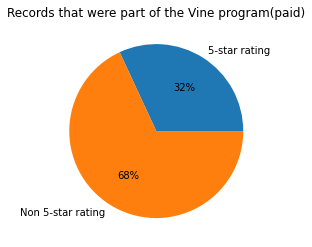

In [ ]:
p=np.array([Percentage_five_star_vine,1-Percentage_five_star_vine])
labels=["5-star rating","Non 5-star rating"]
plt.pie(p,labels=labels,autopct='%1.0f%%')
plt.title("Records that were part of the Vine program(paid)")
plt.show()

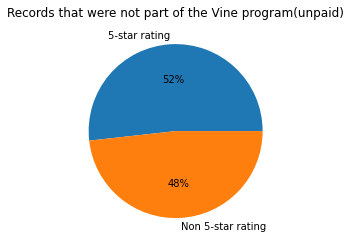

In [ ]:
p=np.array([Percentage_five_star_vine_Unpaid,1-Percentage_five_star_vine_Unpaid])
labels=["5-star rating","Non 5-star rating"]
plt.pie(p,labels=labels,autopct='%1.0f%%')
plt.title("Records that were not part of the Vine program(unpaid)")
plt.show()